In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
from fx_analysis import reer_vol, imf_import, import_imf_dic

In [3]:
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")

### Importing the data

In [4]:
os.chdir('/Users/talespadilha/Dropbox/Soft Power and FX Prediction/Data')
df0 = pd.read_csv('sub_indices.csv', header = [0,1], index_col = [0], parse_dates=True)
sub_indices = df0.loc[:]
latest = sub_indices.iloc[-1]
sub_latest = latest.unstack('subindex').dropna(how='any')

In [5]:
index = pd.read_csv('index.csv', header = [0], index_col = [0], parse_dates=True)
idx_latest = index.iloc[-1]

In [6]:
sub_latest.to_csv('latest.csv')

In [7]:
idx_lates = pd.Series(index.iloc[-1])

<AxesSubplot:>

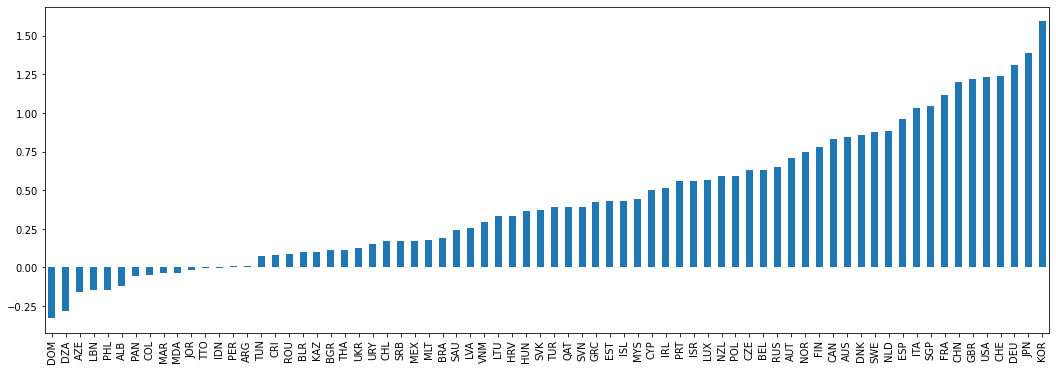

In [8]:
idx_lates.sort_values().plot.bar(figsize = (18, 6))

<AxesSubplot:>

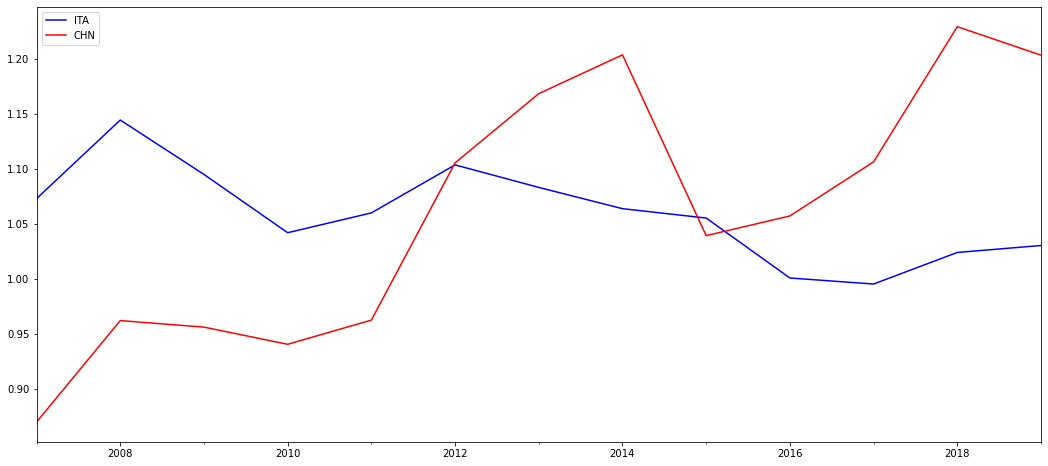

In [9]:
index.reindex(['ITA', 'CHN'], axis=1).plot(figsize = (18, 8), color=['blue', 'red'])

### Clustering Subindices

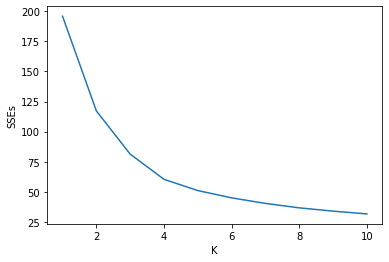

In [10]:
k_range = range(1,11)
sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(sub_latest)
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('SSEs')
plt.plot(k_range, sse)

Estimating the model with optimal K:

In [11]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict(sub_latest)
sub_latest['cluster'] = clusters
sub_latest.head()

subindex,comercial,culture,digital,education,global_reach,institutions,cluster
country,,,,,,,
ALB,-0.034137,0.028434,-0.110118,-0.476981,0.034524,-0.169885,0
ARG,-0.037861,0.443124,0.357636,-0.636241,0.149271,-0.210996,0
AUS,0.497662,0.956996,0.383079,1.649425,0.254249,1.327937,1
AUT,0.676156,0.493576,0.530782,1.118692,0.140016,1.302065,1
AZE,0.153189,-0.028908,0.237998,-0.850041,0.087886,-0.538598,0


In [12]:
sub_latest.to_csv('groups.csv')

In [13]:
for i in range(0,4):
    ccs = sub_latest[sub_latest['cluster']==i].index
    print(f"Countries in {i}")
    print(ccs)

Countries in 0
Index(['ALB', 'ARG', 'AZE', 'BGR', 'BLR', 'BRA', 'CHL', 'COL', 'CRI', 'DOM',
       'DZA', 'IDN', 'JOR', 'KAZ', 'LBN', 'MAR', 'MDA', 'MEX', 'MLT', 'MYS',
       'PAN', 'PER', 'PHL', 'QAT', 'ROU', 'SAU', 'SRB', 'THA', 'TTO', 'TUN',
       'TUR', 'UKR', 'URY', 'VNM'],
      dtype='object', name='country')
Countries in 1
Index(['AUS', 'AUT', 'BEL', 'CAN', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'GRC',
       'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR',
       'NZL', 'POL', 'PRT', 'SGP', 'SVK', 'SVN', 'SWE'],
      dtype='object', name='country')
Countries in 2
Index(['CHE', 'CHN', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA', 'RUS', 'USA'], dtype='object', name='country')
Countries in 3
Index(['JPN', 'KOR'], dtype='object', name='country')


In [14]:
for i in range(0,4):
    ccs = sub_latest[sub_latest['cluster']==i].index
    print(f"Countries in {i}")
    print(ccs)

Countries in 0
Index(['ALB', 'ARG', 'AZE', 'BGR', 'BLR', 'BRA', 'CHL', 'COL', 'CRI', 'DOM',
       'DZA', 'IDN', 'JOR', 'KAZ', 'LBN', 'MAR', 'MDA', 'MEX', 'MLT', 'MYS',
       'PAN', 'PER', 'PHL', 'QAT', 'ROU', 'SAU', 'SRB', 'THA', 'TTO', 'TUN',
       'TUR', 'UKR', 'URY', 'VNM'],
      dtype='object', name='country')
Countries in 1
Index(['AUS', 'AUT', 'BEL', 'CAN', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'GRC',
       'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR',
       'NZL', 'POL', 'PRT', 'SGP', 'SVK', 'SVN', 'SWE'],
      dtype='object', name='country')
Countries in 2
Index(['CHE', 'CHN', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA', 'RUS', 'USA'], dtype='object', name='country')
Countries in 3
Index(['JPN', 'KOR'], dtype='object', name='country')


In [15]:
# Adding index
sub_latest['index'] = idx_latest

In [16]:
sub_latest.columns = ['Commercial Prowess', 'Culture', 'Digital Footprint', 'Education', 'Global Reach', 'Institutions', 'cluster', 'Soft Power Index']

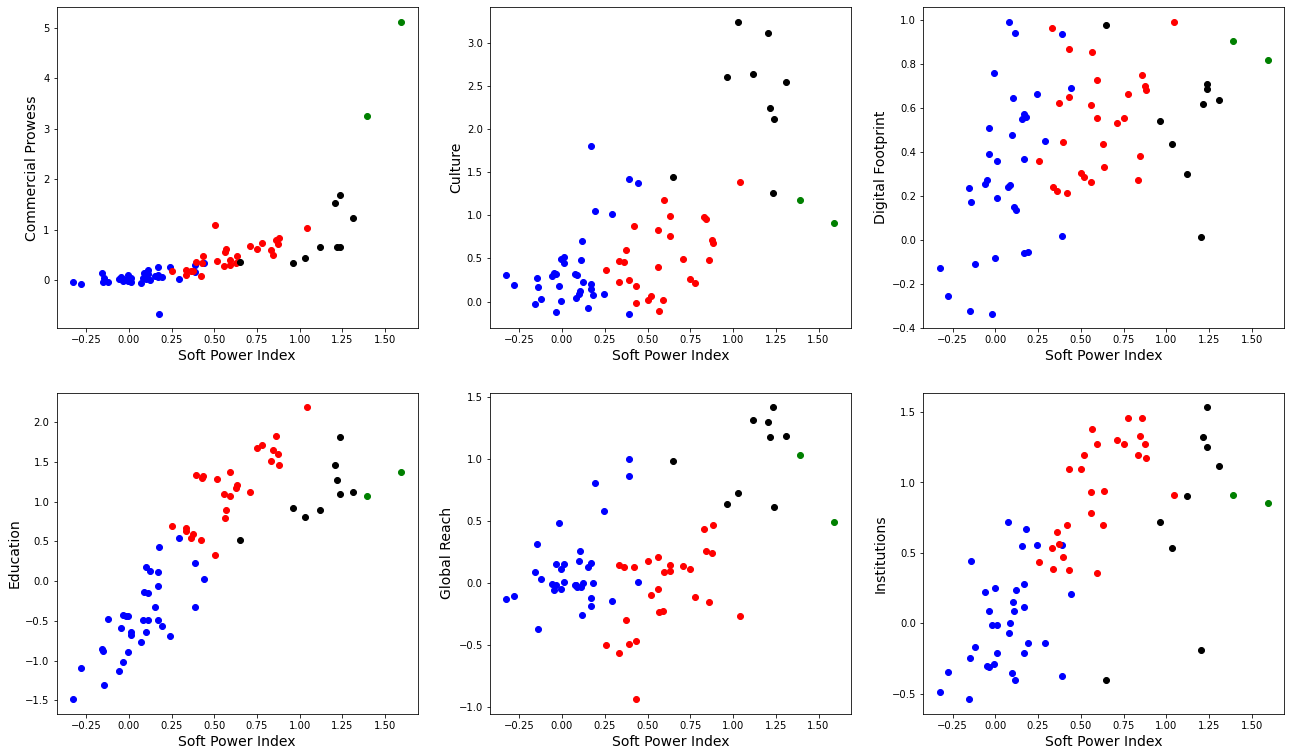

In [17]:
# Prep Plot
df0 = sub_latest[sub_latest['cluster']==0]
df1 = sub_latest[sub_latest['cluster']==1]
df2 = sub_latest[sub_latest['cluster']==2]
df3 = sub_latest[sub_latest['cluster']==3]
columns = ['Commercial Prowess', 'Culture', 'Digital Footprint', 'Education', 'Global Reach', 'Institutions']
# Plot
fig, ax = plt.subplots(2, 3, figsize = (22, 13))
ids = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
for id_key, col in enumerate(columns, 0):
    idx = ids[id_key]
    ax[idx].plot(df0['Soft Power Index'], df0[col], 'o', color='blue')
    ax[idx].plot(df1['Soft Power Index'], df1[col], 'o', color='red')
    ax[idx].plot(df2['Soft Power Index'], df2[col], 'o', color='black')
    ax[idx].plot(df3['Soft Power Index'], df3[col], 'o', color='green')
    ax[idx].set_xlabel('Soft Power Index', fontsize=14)
    ax[idx].set_ylabel(col, fontsize=14)

In [18]:
pd.Series(index.columns.unique()).to_csv('final_list.csv')

### Checking REER

In [19]:
cc_dict = import_imf_dic()
reer0 = imf_import('Raw Data/', 'reer_imf.xlsx')
reer = reer0.rename(columns=cc_dict)
fx_vol = reer_vol(reer)

In [20]:
regimes = pd.read_csv('fx_regime.csv', index_col = [1])[['Regime']]
ff = list(regimes.loc[regimes.Regime=='ff'].index)
cl = list(regimes.loc[regimes.Regime=='cl'].index)
all_ccs = ff

In [21]:
fxvol_ccs = pd.concat({'fx_vol': fx_vol.reindex(all_ccs, axis=1)}, axis=1).loc['2007-01-01':'2019-12-31']
index_ccs =  pd.concat({'index': index.reindex(all_ccs, axis=1)}, axis=1).loc['2007-01-01':'2019-12-31']

In [22]:
from control_variables import import_control

In [23]:
fxvol_l1 = pd.concat({'fx_vol_l1': fx_vol.shift(1).reindex(all_ccs, axis=1)}, axis=1).loc['2007-01-01':'2019-12-31']
fxvol_l2 = pd.concat({'fx_vol_l2': fx_vol.shift(2).reindex(all_ccs, axis=1)}, axis=1).loc['2007-01-01':'2019-12-31']

In [24]:
ct_vars = import_control('2007-01-01', '2019-12-31')

### Proper evaluation

## Overall Estimations

In [28]:
from linearmodels import PooledOLS, PanelOLS
import statsmodels.api as sm

In [29]:
full_df = pd.concat([ct_vars.reindex(all_ccs, axis=1, level='country'), fxvol_ccs, fxvol_l1, fxvol_l2, index_ccs], axis=1)
regressors = ['fx_vol_l1', 'fx_vol_l2', 'bca', 'concent', 'credit', 'gov_spending', 'infla','l_product', 'market_cap', 'tot', 'trade', 'index']

In [30]:
stacked_df = full_df.stack().dropna(how='any').reorder_levels([1,0]).sort_index()
y = stacked_df.xs('fx_vol', axis=1)
X = stacked_df.xs(regressors, axis=1)

In [31]:
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.4549
Estimator:,PanelOLS,R-squared (Between):,-0.7134
No. Observations:,429,R-squared (Within):,0.3717
Date:,"Mon, Jan 03 2022",R-squared (Overall):,-0.5464
Time:,15:42:15,Log-likelihood,-173.81
Cov. Estimator:,Unadjusted,,
,,F-statistic:,25.806
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(12,371)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,25.806


In [32]:
sub_indices.columns.names = ['variable', 'country']
sub_idx_ccs = sub_indices.reindex(all_ccs, axis=1, level='country').loc['2007-01-01':'2019-12-31']

In [33]:
full_df = pd.concat([ct_vars.reindex(all_ccs, axis=1, level='country'), fxvol_ccs, sub_idx_ccs, fxvol_l1, fxvol_l2], axis=1)
regressors = ['fx_vol_l1', 'fx_vol_l2', 'bca', 'concent', 'credit', 'gov_spending', 'infla','l_product', 'market_cap', 'tot', 'trade', 
              'comercial', 'culture', 'digital', 'education', 'global_reach', 'institutions']

In [34]:
stacked_df = full_df.stack().dropna(how='any').reorder_levels([1,0]).sort_index()
y = stacked_df.xs('fx_vol', axis=1)
X = stacked_df.xs(regressors, axis=1)

In [35]:
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.4676
Estimator:,PanelOLS,R-squared (Between):,-2.3521
No. Observations:,429,R-squared (Within):,0.3776
Date:,"Mon, Jan 03 2022",R-squared (Overall):,-1.9770
Time:,15:42:43,Log-likelihood,-168.76
Cov. Estimator:,Unadjusted,,
,,F-statistic:,18.910
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(17,366)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,18.910


In [36]:
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.4676
Estimator:,PanelOLS,R-squared (Between):,-2.3521
No. Observations:,429,R-squared (Within):,0.3776
Date:,"Mon, Jan 03 2022",R-squared (Overall):,-1.9770
Time:,15:43:02,Log-likelihood,-168.76
Cov. Estimator:,Unadjusted,,
,,F-statistic:,18.910
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(17,366)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,18.910


## Overall Analyis

Doing some stuff to understand the panel class

In [37]:
full_df = pd.concat([ct_vars.reindex(all_ccs, axis=1, level='country'), fxvol_ccs, fxvol_l1, fxvol_l2, index_ccs], axis=1)
regressors = ['fx_vol_l1', 'fx_vol_l2', 'bca', 'concent', 'credit', 'gov_spending', 'infla','l_product', 'market_cap', 'tot', 'trade', 'index']

### Pooled Panel

In [38]:
stacked_df = full_df.stack().dropna(how='any').reorder_levels([1,0]).sort_index()
y = stacked_df.xs('fx_vol', axis=1)
X = sm.add_constant(stacked_df.xs(regressors, axis=1))
pooled_res = PooledOLS(y, X).fit(cov_type='clustered', cluster_entity=True)
pooled_res

Dep. Variable:,fx_vol,R-squared:,0.5872
Estimator:,PooledOLS,R-squared (Between):,0.8828
No. Observations:,429,R-squared (Within):,0.2646
Date:,"Mon, Jan 03 2022",R-squared (Overall):,0.5872
Time:,15:43:41,Log-likelihood,-339.76
Cov. Estimator:,Clustered,,
,,F-statistic:,49.309
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(12,416)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,68.538


### Fixed Effects

In [39]:
from linearmodels.panel import PanelOLS

In [40]:
mod = PanelOLS(y, X, entity_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.4161
Estimator:,PanelOLS,R-squared (Between):,0.0503
No. Observations:,429,R-squared (Within):,0.4161
Date:,"Mon, Jan 03 2022",R-squared (Overall):,0.2080
Time:,15:43:55,Log-likelihood,-254.09
Cov. Estimator:,Unadjusted,,
,,F-statistic:,22.746
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(12,383)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,22.746


In [41]:
from linearmodels.panel import compare

In [42]:
compare({"FE": fe_res, "Pooled": pooled_res}, precision='pvalues')

,FE,Pooled
Dep. Variable,fx_vol,fx_vol
Estimator,PanelOLS,PooledOLS
No. Observations,429,429
Cov. Est.,Unadjusted,Clustered
R-squared,0.4161,0.5872
R-Squared (Within),0.4161,0.2646
R-Squared (Between),0.0503,0.8828
R-Squared (Overall),0.2080,0.5872
F-statistic,22.746,49.309
P-value (F-stat),0.0000,0.0000


## Subindices

### Pooled

In [43]:
sub_indices.columns.names = ['variable', 'country']
sub_idx_ccs = sub_indices.reindex(all_ccs, axis=1, level='country').loc['2007-01-01':'2019-12-31']

In [44]:
full_df = pd.concat([ct_vars.reindex(all_ccs, axis=1, level='country'), fxvol_ccs, sub_idx_ccs, fxvol_l1, fxvol_l2], axis=1)
regressors = ['fx_vol_l1', 'bca', 'concent', 'credit', 'gov_spending', 'infla','l_product', 'market_cap', 'tot', 'trade', 
              'comercial', 'culture', 'digital', 'education', 'global_reach', 'institutions']

In [45]:
stacked_df = full_df.stack().dropna(how='any').reorder_levels([1,0]).sort_index()
y = stacked_df.xs('fx_vol', axis=1)
X = sm.add_constant(stacked_df.xs(regressors, axis=1))
pooled_res = PooledOLS(y, X).fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
pooled_res

Dep. Variable:,fx_vol,R-squared:,0.6100
Estimator:,PooledOLS,R-squared (Between):,0.8985
No. Observations:,429,R-squared (Within):,0.2926
Date:,"Mon, Jan 03 2022",R-squared (Overall):,0.6100
Time:,15:44:16,Log-likelihood,-327.57
Cov. Estimator:,Clustered,,
,,F-statistic:,40.274
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(16,412)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,41.552


In [46]:
stacked_df = full_df.stack().dropna(how='any').reorder_levels([1,0]).sort_index()
y = stacked_df.xs('fx_vol', axis=1)
X = sm.add_constant(stacked_df.xs(regressors, axis=1))
pooled_res = PooledOLS(y, X).fit()
pooled_res

Dep. Variable:,fx_vol,R-squared:,0.6100
Estimator:,PooledOLS,R-squared (Between):,0.8985
No. Observations:,429,R-squared (Within):,0.2926
Date:,"Mon, Jan 03 2022",R-squared (Overall):,0.6100
Time:,15:44:21,Log-likelihood,-327.57
Cov. Estimator:,Unadjusted,,
,,F-statistic:,40.274
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(16,412)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,40.274


In [47]:
X = stacked_df.xs(regressors, axis=1)

In [48]:
X_dummy = X.copy()
for yy in range(2007,2020):
    X_dummy[yy] = 0
    X_dummy[yy][X_dummy[yy].index.get_level_values(1).year==yy] = 1

/Users/talespadilha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/talespadilha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/talespadilha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [49]:
mod = PanelOLS(y, X_dummy, entity_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.5806
Estimator:,PanelOLS,R-squared (Between):,-3.1155
No. Observations:,429,R-squared (Within):,0.5806
Date:,"Mon, Jan 03 2022",R-squared (Overall):,-1.4672
Time:,15:44:59,Log-likelihood,-183.13
Cov. Estimator:,Unadjusted,,
,,F-statistic:,18.144
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(28,367)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,23.357


In [50]:
X = sm.add_constant(stacked_df.xs(regressors, axis=1))

In [51]:
mod = PanelOLS(y, X, time_effects=True, entity_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.4307
Estimator:,PanelOLS,R-squared (Between):,-3.1123
No. Observations:,429,R-squared (Within):,0.3446
Date:,"Mon, Jan 03 2022",R-squared (Overall):,-1.5771
Time:,15:45:17,Log-likelihood,-183.13
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.356
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(16,367)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,17.356


In [52]:
mod = PanelOLS(y, X, time_effects=True, entity_effects=True)
fe_res = mod.fit()
fe_res

Dep. Variable:,fx_vol,R-squared:,0.4307
Estimator:,PanelOLS,R-squared (Between):,-3.1123
No. Observations:,429,R-squared (Within):,0.3446
Date:,"Mon, Jan 03 2022",R-squared (Overall):,-1.5771
Time:,15:47:41,Log-likelihood,-183.13
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.356
Entities:,44,P-value,0.0000
Avg Obs:,9.7500,Distribution:,"F(16,367)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,17.356


In [53]:
compare({"FE": fe_res, "Pooled": pooled_res}, precision='pvalues')

,FE,Pooled
Dep. Variable,fx_vol,fx_vol
Estimator,PanelOLS,PooledOLS
No. Observations,429,429
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.4307,0.6100
R-Squared (Within),0.3446,0.2926
R-Squared (Between),-3.1123,0.8985
R-Squared (Overall),-1.5771,0.6100
F-statistic,17.356,40.274
P-value (F-stat),0.0000,0.0000


In [54]:
plt_dict = {}
plt_dict['fx_vol'] = fx_vol.reindex(all_ccs, axis=1)
plt_dict['index'] = index.reindex(all_ccs, axis=1)
plt_data = pd.concat(plt_dict, axis=1).stack(level=1).dropna()

In [55]:
plt_data['cluster'] = np.nan
for i in plt_data.index:
    plt_data.loc[i, 'cluster'] = sub_latest.loc[i[1]]['cluster']

Text(0, 0.5, 'REER Volatility')

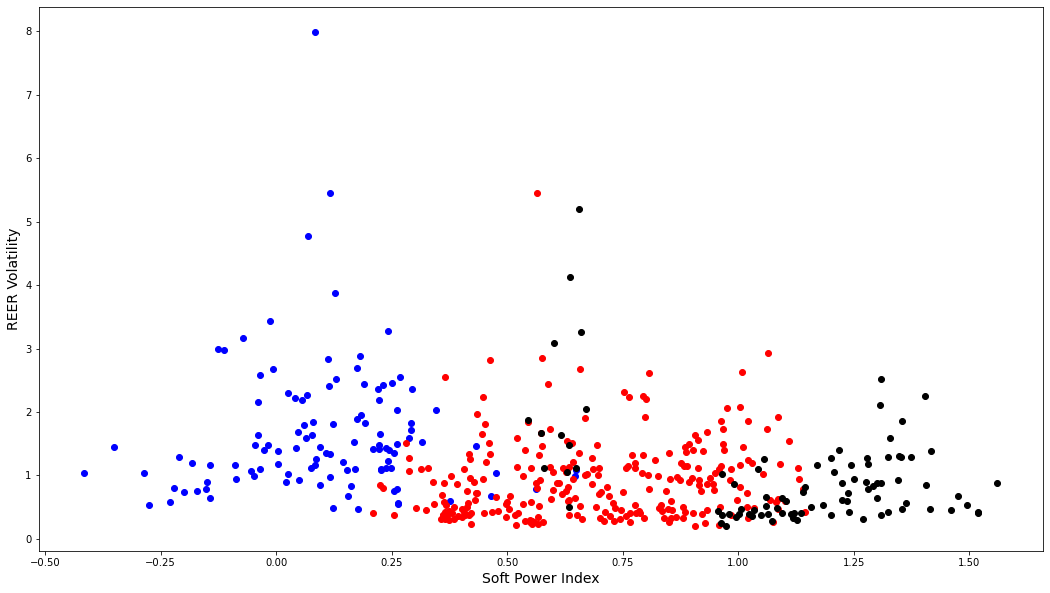

In [56]:
# Prep Plot
df0 = plt_data[plt_data['cluster']==0]
df1 = plt_data[plt_data['cluster']==1]
df2 = plt_data[plt_data['cluster']==2]
#df3 = plt_data[plt_data['cluster']==3]
plt.figure(figsize=(18, 10))
plt.scatter(df0['index'], df0.fx_vol, color='blue')
plt.scatter(df1['index'], df1.fx_vol, color='red')
plt.scatter(df2['index'], df2.fx_vol, color='black')
#plt.scatter(df3['index'], df3.fx_vol, color='green')
plt.xlabel('Soft Power Index', fontsize=14)
plt.ylabel('REER Volatility', fontsize=14)